In [29]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import math

Tworzenie środowiska

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

Reset środowiska

In [ ]:
observation, info = env.reset(seed=123, options={"low": -0.1, "high": 0.1})

(array([ 0.03647037, -0.0892358 , -0.05592803, -0.06312564], dtype=float32),
 {})

Wyliczenie stanów dla 100 kroków 

In [24]:
frames = []

for _ in range(100):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    frame = env.render()
    frames.append(frame)
    if terminated or truncated:
        obs, info = env.reset(seed=123, options={"low": -0.1, "high": 0.1})

env.close()

Animacja

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

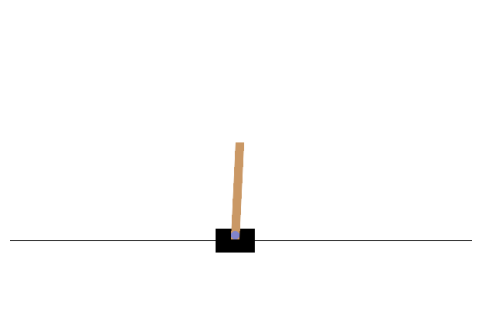

In [25]:
fig = plt.figure(figsize=(6, 4))
img = plt.imshow(frames[0])
plt.axis('off')

In [26]:
def animate(i):
    img.set_array(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=20, blit=True)

In [ ]:
HTML(ani.to_jshtml())

Dyskretyzacja stanów

In [30]:
num_buckets = (1, 1, 6, 12)  # ilość przedziałów dla każdej zmiennej stanu
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_bounds[1] = [-0.5, 0.5] 
state_bounds[3] = [-math.radians(50), math.radians(50)]  

def discretize_state(state):
    ratios = [(state[i] - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0]) for i in range(len(state))]
    new_state = [int(round((num_buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(num_buckets[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

Implementacja algorytmu Q-learning

In [36]:
q_table = np.zeros(num_buckets + (env.action_space.n,))

# Hiperparametry
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
episodes = 1000
max_steps = 200

rewards = []

for episode in range(episodes):
    current_state = discretize_state(env.reset()[0])
    total_reward = 0
    
    for step in range(max_steps):
        # Wybór akcji
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[current_state])
        
        obs, reward, done, _, _ = env.step(action)
        new_state = discretize_state(obs)

        # Aktualizacja Q-wartości
        best_future_q = np.max(q_table[new_state])
        q_table[current_state][action] += learning_rate * (reward + discount_factor * best_future_q - q_table[current_state][action])
        
        current_state = new_state
        total_reward += reward

        if done:
            break
    
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: avg reward: {np.mean(rewards[-100:])}")


Episode 100: avg reward: 15.91
Episode 200: avg reward: 14.54
Episode 300: avg reward: 14.29
Episode 400: avg reward: 15.43
Episode 500: avg reward: 14.38
Episode 600: avg reward: 15.13
Episode 700: avg reward: 15.08
Episode 800: avg reward: 15.85
Episode 900: avg reward: 15.85
Episode 1000: avg reward: 16.51


Testowanie wytrenowanego agenta

In [37]:
for episode in range(episodes):
    current_state = discretize_state(env.reset()[0])
    for step in range(max_steps):
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[current_state])
        obs, reward, done, _, _ = env.step(action)
        new_state = discretize_state(obs)
        best_future_q = np.max(q_table[new_state])
        q_table[current_state][action] += learning_rate * (reward + discount_factor * best_future_q - q_table[current_state][action])
        current_state = new_state
        if done:
            break
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

Animacja

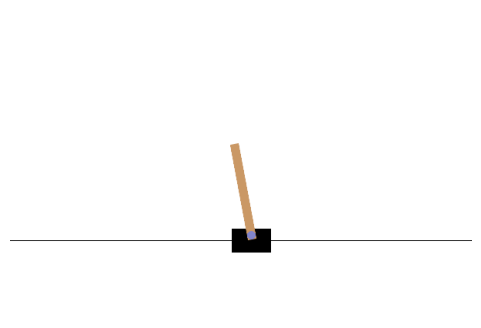

In [38]:
frames = []
state = discretize_state(env.reset()[0])
done = False

while not done:
    frame = env.render()
    frames.append(frame)
    action = np.argmax(q_table[state])
    obs, reward, done, _, _ = env.step(action)
    state = discretize_state(obs)

env.close()

# Tworzenie animacji
fig = plt.figure(figsize=(6, 4))
img = plt.imshow(frames[0])

def animate(i):
    img.set_array(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=20, blit=True)
plt.axis('off')

HTML(ani.to_jshtml())